# Illustration des processus de file d'attente


## Objectif général

L’objectif de cette séance est de comprendre le fonctionnement d’une file d’attente **M/M/1**   (arrivées de type Poisson, services exponentiels, un seul serveur) et d’implémenter une simulation complète du système afin d’en estimer les grandeurs de performance.

# Partie I : Simulation des files M/M/1

### **Question 1 – Simulation des arrivées, services et départs**

On considère une file d’attente à un seul serveur, sous les hypothèses classiques suivantes :

- Les interarrivées $ Q_k \sim \text{Exp}(\lambda) $
- Les temps de service $ S_k \sim \text{Exp}(\mu) $
- Les clients sont servis dans l’ordre d’arrivée (FIFO)

On note :
- $ T_n = \sum_{k=1}^n Q_k $ : instant d’arrivée du $ n $-ième client
- $ D_n $ : instant de départ du $ n $-ième client
- $ A_t $ : processus de comptage des arrivées
- $ D_t $ : processus de comptage des départs

On suppose que le système est initialement vide.

### Travail demandé
1. Simuler les **interarrivées** $ Q_k \sim \text{Exp}(\lambda) $ et les **temps de service** $ S_k \sim \text{Exp}(\mu) $.
2. En déduire les **instants d’arrivées** $ T_n $ et les **instants de départs** $ D_n $ sous la dynamique suivante :
   $$
   \begin{cases}
   D_1 = T_1 + S_1 \\[3pt]
   D_n = \max(T_n, D_{n-1}) + S_n, \quad n \ge 2
   \end{cases}
   $$
3. Vérifier que les départs sont bien ordonnés et croissants.

Vous pouvez renvoyer les trois tableaux `T_n`, `S_k`, et `D_n`.

**Attention — Simulation avec NumPy**

Lors de la génération de variables exponentielles sous Python avec `np.random.exponential`,  
la fonction attend **le paramètre de moyenne** (ou période moyenne des interarrivées) et non le **taux**.

Autrement dit :
$$
\text{si } X \sim \mathrm{Exp}(\lambda), \quad \text{alors } X = \text{np.random.exponential}(1 / \lambda)
$$

En pratique, on renseigne `scale = 1 / lambda_rate` et non `scale = lambda_rate`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ===============================================================
# Simulation of arrivals, service times, and departures
# ===============================================================

def simulate_arrivals_services(n_customers: int, lambda_rate: float, mu_rate: float, seed: int = 777):
    """
    Simulate arrival times, service times, and departure times for a simple queueing system (M/M/1).
    
    Parameters
    ----------
    n_customers : int
        Number of customers to simulate.
    lambda_rate : float
        Arrival rate λ (mean interarrival time = 1/λ).
    mu_rate : float
        Service rate μ (mean service time = 1/μ).
    seed : int, optional
        Random seed for reproducibility (default=777).
    
    Returns
    -------
    arrivals : np.ndarray
        Arrival times of customers.
    services : np.ndarray
        Service times (duration of service for each customer).
    departures : np.ndarray
        Departure times of customers.
    
    Notes
    -----
    - Interarrival times follow Exp(λ).
    - Service times follow Exp(μ).
    - Departures are computed assuming a single server (M/M/1):
        * each customer starts service when both they and the server are ready.
    """
    np.random.seed(seed)
    
    # Generate interarrival times Q_k ~ Exp(λ)
    Q_k = np.random.exponential(scale=1/lambda_rate, size=n_customers)

    # Compute cumulative arrival epochs T_n = Σ_{i=1}^n Q_i
    T_n = np.cumsum(Q_k)

    # Generate service times S_k ~ Exp(μ)
    S_k = np.random.exponential(scale=1/mu_rate, size=n_customers)

    # Initialize start-of-service times B_n and departure times D_n
    B_n = np.zeros(n_customers)
    D_n = np.zeros(n_customers)

    for k in range(n_customers):
        if k == 0:
            # Case 1: first customer — server is idle,
            # so service starts immediately at arrival epoch T_1.
            B_n[k] = T_n[k]
        else:
            # Case 2: next customers — they can only start service when both:
            #   - they have arrived (T_n[k])
            #   - the previous customer has departed (D_n[k-1])
            # Hence, service starts at max(T_n[k], D_n[k-1]).
            B_n[k] = max(T_n[k], D_n[k-1])
        
        # Departure epoch
        D_n[k] = B_n[k] + S_k[k]
    
    # A_t (arrival process) could be defined as the counting process
    # A_t = #{k : T_n[k] ≤ t}, not explicitly returned here.
    return T_n, S_k, D_n

### **Question 2 – Simulation complète d’une file M/M/1**

Le but de cette question est de construire progressivement une simulation complète du système.  
Vous allez implémenter trois fonctions principales : `run_mm1`, `count_customers_in_system`, et `compute_mm1_metrics`.

#### **2.1. Fonction `run_mm1` – Simulation complète**

Cette fonction doit renvoyer toutes les grandeurs utiles associées à la file d’attente.  
On rappelle les notations :

- $ T_n $ : instants d’arrivée  
- $ B_n $ : instants de début de service  
- $ D_n $ : instants de départ  
- $ W_q = B_n - T_n $ : temps d’attente en file  
- $ W = D_n - T_n $ : temps total passé dans le système  
- $ S_k $ : temps de service

Compléter le code pour :

1. Appeler la fonction précédente simulant $ T_n, S_k, D_n $.
2. Calculer les temps de **début de service**, les **temps d’attente** $ W_q $ et les **temps de séjour** $ W $.
3. Renvoyer un dictionnaire contenant toutes ces variables.

In [3]:
# =======================================================================
# Full M/M/1 simulation — compute waiting, service, and system times
# =======================================================================

def run_mm1(n_customers: int, lambda_rate: float, mu_rate: float, seed: int = 777):
    """
    Run a complete simulation of an M/M/1 queue.
    
    Parameters
    ----------
    n_customers : int
        Number of customers to simulate.
    lambda_rate : float
        Arrival rate λ.
    mu_rate : float
        Service rate μ.
    seed : int, optional
        Random seed for reproducibility.
    
    Returns
    -------
    results : dict
        Dictionary containing arrays of:
        - T_n : arrival epochs
        - B_n : start of service times
        - D_n : departure epochs
        - W_q : waiting times in queue
        - S_k : service times
        - W : total time in system
    """
    # Generate arrival epochs T_n, service times S_k, and departures D_n
    (
        T_n, # 'arrivals'
        S_k, # 'services'
        D_n  # 'departures'
    ) = simulate_arrivals_services(n_customers, lambda_rate, mu_rate, seed)
    
    # Initialize start-of-service times, waiting times (W_q), and system times (W)
    B_n = np.zeros(n_customers)  # 'start_service'
    W_q = np.zeros(n_customers)   # 'waiting_times'
    W = np.zeros(n_customers)     # 'system_times'
    
    for k in range(n_customers):
        if k == 0:
            # Case 1: first customer — the server is idle,
            # so service begins right at the arrival epoch T_1.
            B_n[k] = T_n[k]
        else:
            # Case 2: next customers — they can only start service when both:
            #   - they have arrived (T_n[k])
            #   - the previous customer has departed (D_n[k-1])
            # Hence, service starts at max(T_n[k], D_n[k-1]).
            B_n[k] = max(T_n[k], D_n[k-1])
        
        # Waiting time in queue: W_q = B_n - T_n
        W_q[k] = B_n[k] - T_n[k]
        
        # Total time in system: W = D_n - T_n
        W[k] = D_n[k] - T_n[k]
    
    # Return all key variables using the mathematical notations
    results = {
        "T_n": T_n,   # Arrival epochs
        "B_n": B_n,   # Start of service times
        "D_n": D_n,   # Departure epochs
        "W_q": W_q,   # Waiting times
        "S_k": S_k,   # Service durations
        "W": W,       # System times
    }
    
    return results

### **2.2. Fonction – Processus de comptage**

Cette fonction doit calculer :

$
N_t = \#\{n : T_n \le t < D_n\}
\]

autrement dit, **le nombre de clients présents dans le système à l’instant $ t $**.

Compléter la fonction pour :

1. Calculer le nombre de clients dans le système à chaque instant $ t $ de la grille de temps.
2. Renvoyer le vecteur $ N_t $ correspondant.
3. Vérifier que la courbe obtenue est bien en escalier, avec des sauts uniquement aux instants $ T_n $ et $ D_n $.


Compléter la fonction pour :

1. Calculer le nombre de clients présents dans le système à chaque instant $ t $ de la grille de temps.
2. Renvoyer le vecteur $ N_t $ correspondant.
3. Vérifier que la courbe obtenue est bien en escalier, avec des sauts uniquement aux instants $ T_n $ et $ D_n $.

In [4]:
# ===================================================================
# Counting process N_t — number of customers in system over time
# ===================================================================

def count_customers_in_system(times: np.ndarray, T_n: np.ndarray, D_n: np.ndarray):
    """
    Compute the counting process N_t = #{n : T_n <= t < D_n},
    i.e., the number of customers present in the system at time t.
    
    Parameters
    ----------
    times : np.ndarray
        Time grid where N_t is evaluated.
    T_n : np.ndarray
        Arrival epochs of customers.
    D_n : np.ndarray
        Departure epochs of customers.
    
    Returns
    -------
    N_t : np.ndarray
        Number of customers in the system at each time t.
    """
    N_t = np.zeros_like(times)
    for i, t in enumerate(times):
        # N_t = number of customers who have arrived (T_n <= t)
        #       but have not yet departed (D_n > t)
        N_t[i] = np.sum((T_n <= t) & (D_n > t))
        
    return N_t

#### **2.3. Fonction – Quantités théoriques de performance**

Une fois la simulation opérationnelle, on souhaite comparer les valeurs empiriques aux résultats théoriques issus de la théorie des files d’attente.

Pour un système **M/M/1** stable ($ \lambda < \mu $), on sait que :

$$
\rho = \frac{\lambda}{\mu}, \qquad
L = \frac{\rho}{1 - \rho}, \qquad
L_q = \frac{\rho^2}{1 - \rho}, \qquad
W = \frac{1}{\mu - \lambda}, \qquad
W_q = \frac{\rho}{\mu - \lambda}.
$$

Compléter la fonction afin qu’elle calcule ces valeurs et les renvoie sous forme d’un dictionnaire.  
Vous pourrez ainsi confronter ces quantités théoriques aux estimations issues de la simulation.

In [5]:
# ===============================================================
# Compute performance metrics (Little's Law, PASTA, etc.)
# ===============================================================

def compute_mm1_metrics(lambda_rate: float, mu_rate: float):
    """
    Compute theoretical performance metrics for an M/M/1 queue.
    
    Parameters
    ----------
    lambda_rate : float
        Arrival rate λ.
    mu_rate : float
        Service rate μ.
    
    Returns
    -------
    metrics : dict
        Theoretical quantities for steady-state:
        - rho (traffic intensity)
        - L (average number in system)
        - Lq (average number in queue)
        - W (average time in system)
        - Wq (average waiting time)
    """
    rho = lambda_rate / mu_rate
    if rho >= 1:
        raise ValueError("System is unstable (ρ ≥ 1). Must have λ < μ.")
    
    L = rho / (1 - rho)
    Lq = rho**2 / (1 - rho)
    W = 1 / (mu_rate - lambda_rate)
    Wq = rho / (mu_rate - lambda_rate)
    
    return {"rho": rho, "L": L, "Lq": Lq, "W": W, "Wq": Wq}

### **Question 3 – Application et visualisation**

Dans cette dernière partie, vous allez appliquer les fonctions précédentes afin d’observer le comportement du système et d’en tirer des statistiques globales.

1. **Choisir les paramètres** : fixer des valeurs de $ \lambda $, $ \mu $, et du nombre de clients à simuler.  
   (Veiller à ce que $ \lambda < \mu $ pour garantir la stabilité du système.)

2. **Lancer la simulation complète** à l’aide de votre fonction principale.  
   Vous obtiendrez les variables $ T_n $, $ D_n $, $ S_k $, $ W_q $, $ W $, etc.

3. **Construire une grille temporelle** permettant d’évaluer $ N_t $ sur un intervalle couvrant toute la simulation.

4. **Calculer** :
   - $ N_t $ : nombre total de clients présents dans le système ;
   - $ n_q(t) = \max(N_t - 1, 0) $ : nombre de clients en attente ;
   - $ n_s(t) = \min(N_t, 1) $ : clients en service.  
$\,$

5. **Tracer sur un même graphique verticalement aligné** :
   - le processus $ N_t $ (clients dans le système) ;
   - le processus $ n_q(t) $ (clients dans la file) ;
   - le processus $ n_s(t) $ (clients servis).

   Les trois graphes doivent être synchronisés dans le temps, avec des tracés en escalier.  
   On veillera à ajuster les échelles verticales pour une lecture cohérente :  
   l’axe du second graphe doit avoir la même ordonnée maximale que le premier,  
   et l’axe du troisième doit être borné entre $0$ et $1.5$.

6. **Comparer les moyennes empiriques** (temps d’attente moyen, temps de séjour moyen, nombre moyen de clients)  
   aux valeurs théoriques obtenues via les formules de la question précédente.

7. **Interpréter les résultats** :
   - Vérifier la cohérence avec la loi de Little : $ L = \lambda W $.
   - Observer les effets d’une charge croissante ($ \rho \to 1^- $) sur la taille moyenne de la file et les temps d’attente.
   - Identifier les différences entre temps en file, en service, et dans le système.


--- Theoretical Metrics (M/M/1) ---
  rho = 0.50
    L = 1.00
   Lq = 0.50
    W = 0.20
   Wq = 0.10

--- Empirical Averages ---
Mean waiting time (E[Wq]): 0.10
Mean system time  (E[W]):  0.20


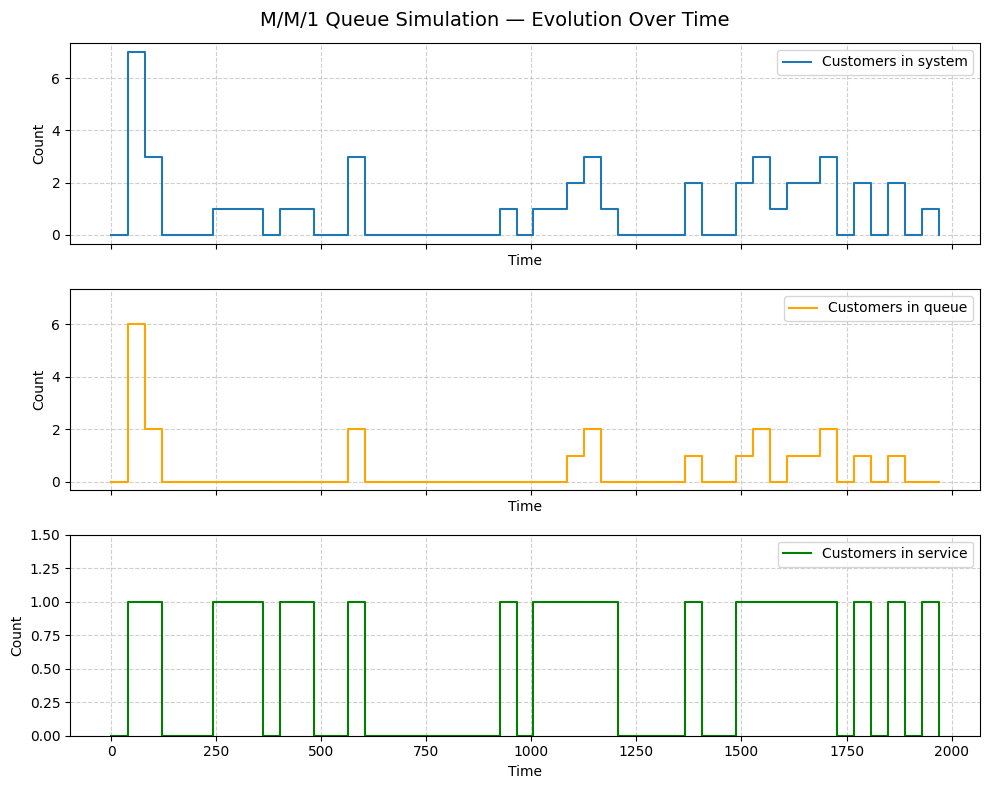

In [6]:
# Parameters
lambda_rate = 5   # Arrival rate (customers per time unit)
mu_rate = 10      # Service rate
n_customers = 10_000

# Run M/M/1 simulation
results = run_mm1(n_customers, lambda_rate, mu_rate)
T_n, D_n = results["T_n"], results["D_n"]

# Time grid for visualization
t_grid = np.linspace(0, D_n[-1], 50)
N_t = count_customers_in_system(t_grid, T_n, D_n)

# Number in queue (excluding service)
n_queue = np.maximum(N_t - 1, 0)
n_service = np.minimum(N_t, 1)

# Theoretical metrics
metrics = compute_mm1_metrics(lambda_rate, mu_rate)
print("\n--- Theoretical Metrics (M/M/1) ---")
for k, v in metrics.items():
    print(f"{k:>5s} = {v:.2f}")

# Empirical averages
print("\n--- Empirical Averages ---")
print(f"Mean waiting time (E[Wq]): {np.mean(results['W_q']):.2f}")
print(f"Mean system time  (E[W]):  {np.mean(results['W']):.2f}")

# Plot evolution over time
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(t_grid, N_t, label="Customers in system", drawstyle="steps-post")
axs[1].plot(t_grid, n_queue, label="Customers in queue", color="orange", drawstyle="steps-post")
axs[1].set_ylim(-0.3, axs[0].get_ylim()[1])
axs[2].plot(t_grid, n_service, label="Customers in service", color="green", drawstyle="steps-post")
axs[2].set_ylim(0, 1.5)

for ax in axs:
    ax.legend()
    ax.set_ylabel("Count")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xlabel("Time")

plt.suptitle("M/M/1 Queue Simulation — Evolution Over Time", fontsize=14)
plt.tight_layout()
plt.show()

### **Question 4 – Comparaison entre résultats empiriques et théoriques**

À partir de votre simulation précédente, on souhaite maintenant comparer les statistiques **empiriques** issues du modèle simulé avec les valeurs **théoriques** d’une file M/M/1.

1. Calculer les grandeurs empiriques :
   - $ \rho = \frac{\lambda}{\mu} $
   - $ W = \mathbb{E}[D_n - T_n] $
   - $ W_q = \mathbb{E}[B_n - T_n] $
   - $ L = \lambda W $ (loi de Little)

2. Comparer ces valeurs avec les résultats théoriques :
   $$
   L = \frac{\rho}{1-\rho}, \quad 
   W = \frac{1}{\mu - \lambda}, \quad
   W_q = \frac{\rho}{\mu - \lambda}.
   $$

In [7]:
# ===============================================================
# Compare empirical vs. theoretical M/M/1 metrics
# ===============================================================

# Compute empirical means
empirical = {
    "rho": lambda_rate / mu_rate,
    "W": np.mean(results["W"]),       # Mean total time in system
    "Wq": np.mean(results["W_q"]),    # Mean waiting time in queue
}

# Little's Law (empirical)
empirical["L"] = lambda_rate * empirical["W"]

# Compute theoretical values
theoretical = compute_mm1_metrics(lambda_rate, mu_rate)

# Display comparison with relative errors
print("\n--- Comparison: Empirical vs. Theoretical ---")
print(f"{'Metric':<8} {'Empirical':>12} {'Theoretical':>15} {'Rel. Error':>15}")
print("-" * 55)

for key in ["rho", "W", "Wq", "L"]:
    emp_val = empirical[key]
    theo_val = theoretical[key]
    rel_error = abs(emp_val - theo_val) / theo_val
    print(f"{key:<8} {emp_val:>12.4f} {theo_val:>15.4f} {rel_error:>15.2e}")


--- Comparison: Empirical vs. Theoretical ---
Metric      Empirical     Theoretical      Rel. Error
-------------------------------------------------------
rho            0.5000          0.5000        0.00e+00
W              0.1974          0.2000        1.31e-02
Wq             0.0984          0.1000        1.65e-02
L              0.9869          1.0000        1.31e-02


# Partie II – Files à capacité finie : le modèle M/M/1/K

Maintenant que l’on sait simuler une file **M/M/1**, c’est-à-dire un système à un seul serveur et capacité illimitée, on s’intéresse au cas plus réaliste où la **capacité totale du système est bornée**.

Le modèle **M/M/1/K** décrit ainsi une file d’attente avec :

- un seul serveur (comme précédemment) ;
- une arrivée des clients selon un processus de Poisson de taux λ ;
- des durées de service exponentielles de paramètre μ ;
- et une capacité maximale **K** (clients en service + en file).

Lorsqu’un client se présente alors que le système contient déjà **K** clients, **il est refusé** (ou perdu).  

L’objectif de cette section est de :
1. simuler la dynamique de ce système en temps continu,  
2. observer l’évolution du nombre de clients dans le système,  
3. comparer la **probabilité empirique de refus** à sa **valeur théorique**, issue de la distribution stationnaire géométrique tronquée.

In [8]:
def simulate_mm1K(lambda_rate: float, mu_rate: float, K: int, T_max: float, seed: int = 777):
    """
    Simulate an M/M/1/K queue (finite capacity) up to a final time T_max.
    """
    np.random.seed(seed)

    t = 0.0
    N = 0
    arrivals_all = []
    arrivals_accepted = []
    departures = []
    refused_times = []

    t_next_arrival = np.random.exponential(1 / lambda_rate)
    t_next_departure = np.inf

    while t < T_max:
        if t_next_arrival < t_next_departure:
            # Arrival
            t = t_next_arrival
            arrivals_all.append(t)
            if N < K:
                N += 1
                arrivals_accepted.append(t)
                if N == 1:
                    # Schedule departure for this customer
                    t_next_departure = t + np.random.exponential(1 / mu_rate)
            else:
                refused_times.append(t)
            t_next_arrival = t + np.random.exponential(1 / lambda_rate)
        else:
            # Departure
            t = t_next_departure
            N -= 1
            departures.append(t)
            if N > 0:
                t_next_departure = t + np.random.exponential(1 / mu_rate)
            else:
                t_next_departure = np.inf

    # --- Correction: handle unequal lengths ---
    arrivals_accepted = np.array(arrivals_accepted)
    departures = np.array(departures)

    # Si plus d’arrivées que de départs (dernier client encore présent)
    if len(arrivals_accepted) > len(departures):
        pad = np.ones(len(arrivals_accepted) - len(departures)) * T_max
        departures = np.concatenate([departures, pad])

    # Si plus de départs (possible numériquement, mais rare)
    if len(departures) > len(arrivals_accepted):
        departures = departures[:len(arrivals_accepted)]

    # --- Compute N(t) ---
    t_grid = np.linspace(0, T_max, 300)
    N_t = np.zeros_like(t_grid)

    for i, tt in enumerate(t_grid):
        N_t[i] = np.sum((arrivals_accepted <= tt) & (departures > tt))

    return {
        "arrivals_all": np.array(arrivals_all),
        "arrivals_accepted": arrivals_accepted,
        "departures": departures,
        "refused_times": np.array(refused_times),
        "t_grid": t_grid,
        "N_t": N_t
    }

In [9]:
def mm1K_stationary(lambda_rate, mu_rate, K):
    """Compute stationary distribution π_n for M/M/1/K."""
    rho = lambda_rate / mu_rate
    if rho == 1:
        pi = np.ones(K + 1) / (K + 1)
    else:
        norm = (1 - rho) / (1 - rho ** (K + 1))
        pi = np.array([norm * rho ** n for n in range(K + 1)])
    return pi

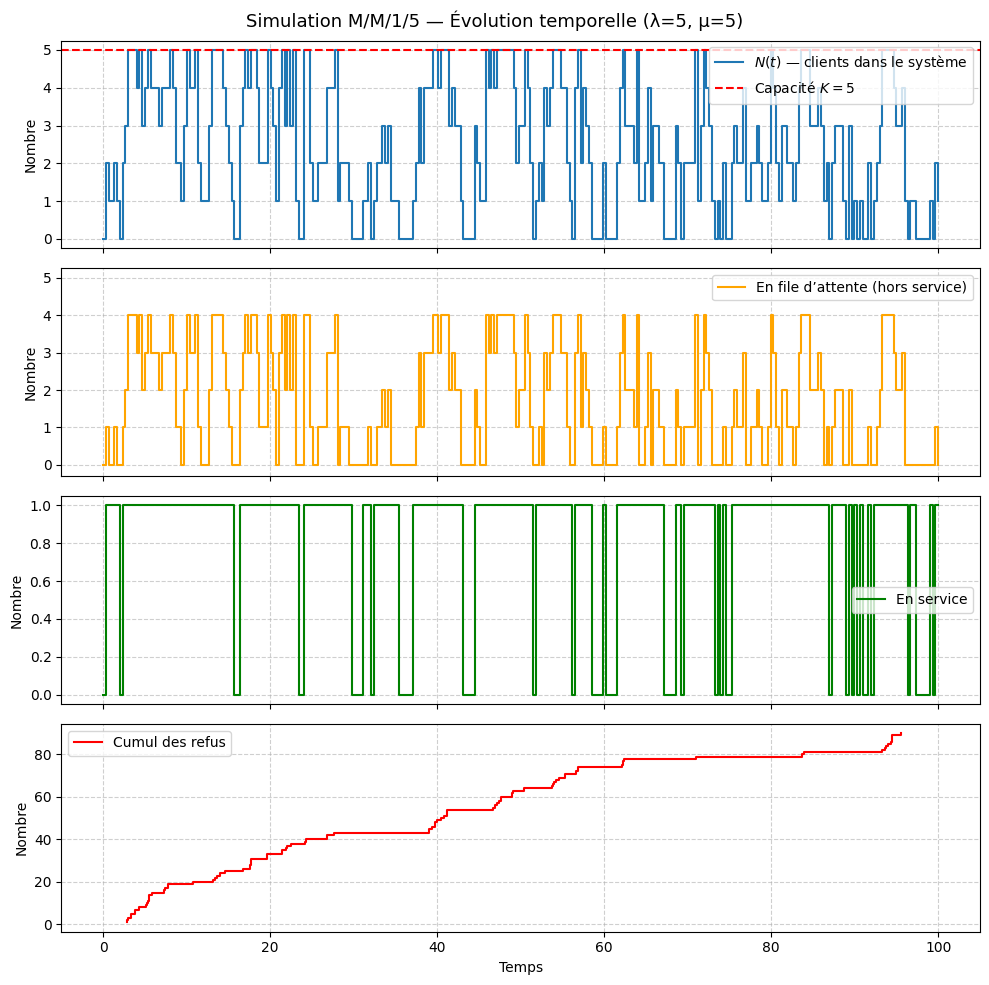

In [18]:
# ===============================================================
# Exemple d'exécution et graphiques
# ===============================================================

lambda_rate = 5
mu_rate = 5
K = 5
T_max = 100

results = simulate_mm1K(lambda_rate, mu_rate, K, T_max)
t_grid = results["t_grid"]
N_t = results["N_t"]
refused_times = results["refused_times"]

# Courbes dérivées
n_queue = np.maximum(N_t - 1, 0)
n_service = np.minimum(N_t, 1)
refused_cum = np.arange(1, len(refused_times) + 1)

# ===============================================================
# Plots
# ===============================================================
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].step(t_grid, N_t, where="post", label=r"$N(t)$ — clients dans le système")
axs[0].axhline(y=K, color="r", linestyle="--", label=fr"Capacité $K={K}$")

axs[1].step(t_grid, n_queue, where="post", color="orange", label="En file d’attente (hors service)")
axs[1].set_ylim(-0.3, axs[0].get_ylim()[1])
axs[2].step(t_grid, n_service, where="post", color="green", label="En service")
axs[3].step(refused_times, np.arange(1, len(refused_times) + 1), color="red", label="Cumul des refus")

for ax in axs:
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_ylabel("Nombre")

axs[-1].set_xlabel("Temps")
plt.suptitle(fr"Simulation M/M/1/{K} — Évolution temporelle (λ={lambda_rate}, μ={mu_rate})", fontsize=13)
plt.tight_layout()
plt.show()

In [15]:
# ===============================================================
# Comparaison proba de refus : empirique vs théorique
# ===============================================================
pi = mm1K_stationary(lambda_rate, mu_rate, K)
P_block_theoretical = pi[-1]
P_block_empirical = len(refused_times) / len(results["arrivals_all"])

print("\n--- Comparaison probabilité de refus ---")
print(f"Théorique : P_block = {P_block_theoretical:.4f}")
print(f"Empirique : P_block = {P_block_empirical:.4f}")
print(f"Erreur relative : {abs(P_block_empirical - P_block_theoretical) / P_block_theoretical:.2e}")


--- Comparaison probabilité de refus ---
Théorique : P_block = 0.0159
Empirique : P_block = 0.0171
Erreur relative : 8.00e-02
